Ce script génère les diagrammes des données du corpus DCU.

In [1]:

from __future__ import absolute_import, division, print_function, unicode_literals

import os
import argparse

import pandas as pd
import matplotlib.pyplot as plt
from data_handler import DataHandler



In [2]:
# parse arguments
## general
arg_parser = argparse.ArgumentParser()
arg_parser.add_argument('--working_path', default='.')

## data
arg_parser.add_argument('dataset_name', default='mimic3',
                        help='The data files should be saved in [working_path]/data/[dataset_name] directory.')
arg_parser.add_argument('label_name', default='mortality')
arg_parser.add_argument('--max_timesteps', type=int, default=200, 
                        help='Time series of at most # time steps are used. Default: 200.')
arg_parser.add_argument('--max_timestamp', type=int, default=48*60*60,
                        help='Time series of at most # seconds are used. Default: 48 (hours).')

## model
arg_parser.add_argument('--recurrent_dim', type=lambda x: x and [int(xx) for xx in x.split(',')] or [], default='64')
arg_parser.add_argument('--hidden_dim', type=lambda x: x and [int(xx) for xx in x.split(',')] or [], default='64')
arg_parser.add_argument('--model', default='GRUD', choices=['GRUD', 'GRUforward', 'GRU0', 'GRUsimple'])
arg_parser.add_argument('--use_bidirectional_rnn', default=False)
                           
## training
arg_parser.add_argument('--pretrained_model_file', default=None,
                        help='If pre-trained model is provided, training will be skipped.') # e.g., [model_name]_[i_fold].h5
arg_parser.add_argument('--epochs', type=int, default=100)
arg_parser.add_argument('--early_stopping_patience', type=int, default=10)
arg_parser.add_argument('--batch_size', type=int, default=2)


## set the actual arguments if running in notebook
if not (__name__ == '__main__' and '__file__' in globals()):
    # '''ARGS = arg_parser.parse_args([
    #     'mimic3',
    #     'mortality',
    #     '--model', 'GRUD',
    #     '--hidden_dim', '',
    #     '--epochs', '100'
    # ])'''
    ARGS = arg_parser.parse_args([
        'detection',
        'risk_situation',
        '--model', 'GRUD',
        '--hidden_dim', '',
        '--max_timestamp', '5807537',
        '--epochs', '100'
    ])
else:
    ARGS = arg_parser.parse_args()

#print('Arguments:', ARGS)

In [3]:
# get dataset
dataset = DataHandler(
    data_path=os.path.join(ARGS.working_path, 'data', ARGS.dataset_name), 
    label_name=ARGS.label_name, 
    max_steps=ARGS.max_timesteps,
    max_timestamp=ARGS.max_timestamp
)

### Embeding

In [4]:
df = pd.DataFrame(dataset._data['input'])
df.columns = ["timestamp","name", "latitude", "longitude", "step","gsr","heart_rate","skin_temp","calories","risk_situation"]
#df = df[pd.notnull(df['risk_situation'])] #-> ça c'est pour enlever toutes les entrées ou il y a NaN ou Null
df.sample(10)

,timestamp,name,latitude,longitude,step,gsr,heart_rate,skin_temp,calories,risk_situation
47307,None,None,18.976417213730365,None,None,None,None,None,None,None
49727,None,None,-5.7144494,None,None,None,None,None,None,None
52946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46202,None,None,18.956774255645,None,None,None,None,None,None,None
32717,1.47317e+09,Clarion Hotel The Edge,53.38654,None,0,5.89E-05,112,88.7,4.7,other
8515,1.47172e+09,NaN,NaN,NaN,0,6.65E-05,143,86.9,10.4,other
3978,1.47145e+09,NaN,NaN,NaN,0,6.65E-05,73,88.7,1.2,other
30330,1.47125e+09,"""Park Inn Radisson Hotel, Gardermoen""",11.108409275,None,NaN,NaN,NaN,NaN,NaN,NaN
45527,None,None,18.956774255645,None,None,None,None,None,None,None
39053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Statistiques par classe

In [5]:
stat = df['risk_situation'].value_counts(dropna=False)
stat

NaN                          30826
other                        21152
fall                          2181
risk_of_domestic_accident      406
risk_of_fall                   347
risk_of_fraud                  120
Name: risk_situation, dtype: int64

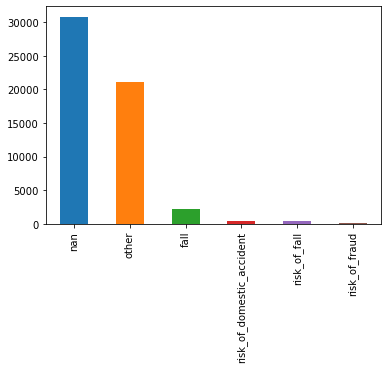

In [6]:
stat.plot(kind='bar')
stat.plot

In [7]:
# Prepare data: throw useless features away
timeDf=df.drop(['latitude','longitude','name', 'risk_situation'],axis=1)
timeDf = timeDf[pd.notnull(timeDf['timestamp'])] #-> ça c'est pour enlever toutes les entrées ou il y a NaN ou Null
timeDf.set_index('timestamp', inplace=True, drop=True)

## GSR

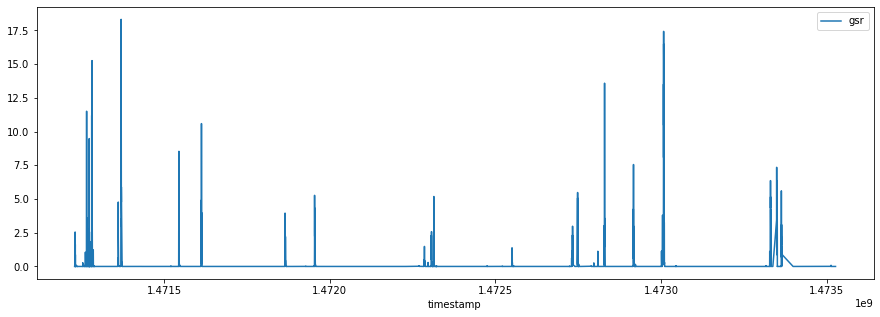

In [8]:
# Plot gsr
timeDfGsr=timeDf.drop(['step','heart_rate', 'skin_temp','calories'],axis=1)
timeDfGsr = timeDfGsr[pd.notnull(timeDfGsr['gsr'])] #-> ça c'est pour enlever toutes les entrées ou il y a NaN ou Null
timeDfGsr=timeDfGsr.astype(float)
timeDfGsr=timeDfGsr.sort_index(axis=0)
plt.rcParams.update({'figure.figsize': (15,5)})
timeDfGsr.plot()

## Heart Rate

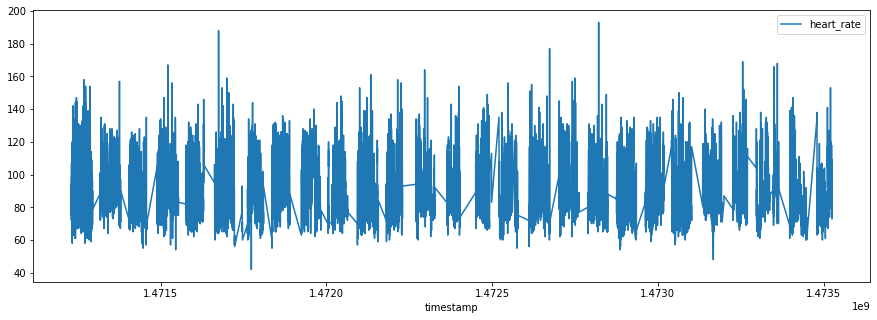

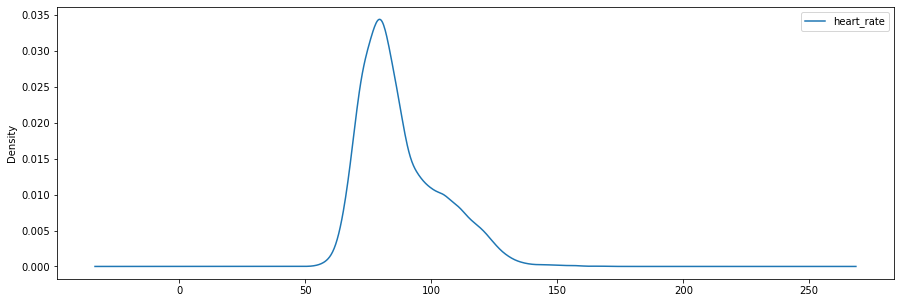

In [9]:
# Plot heart_rate
timeDfHr=timeDf.drop(['step','gsr', 'skin_temp','calories'],axis=1)
timeDfHr = timeDfHr[pd.notnull(timeDfHr['heart_rate'])] #-> ça c'est pour enlever toutes les entrées ou il y a NaN ou Null
timeDfHr=timeDfHr.astype(float)
timeDfHr=timeDfHr.sort_index(axis=0)
plt.rcParams.update({'figure.figsize': (15,5)})
timeDfHr.plot()
timeDfHr.plot.kde()

## Skin temp

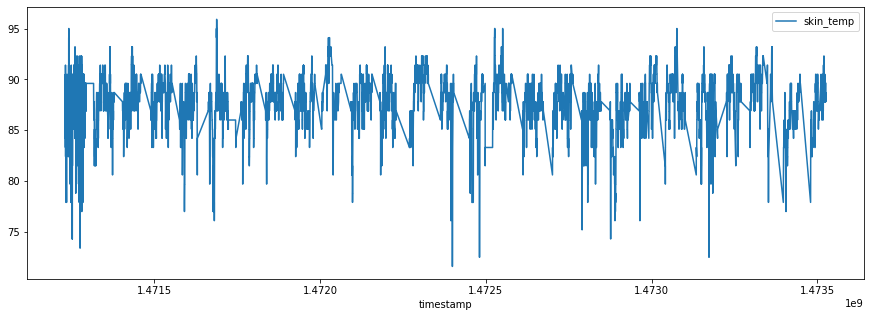

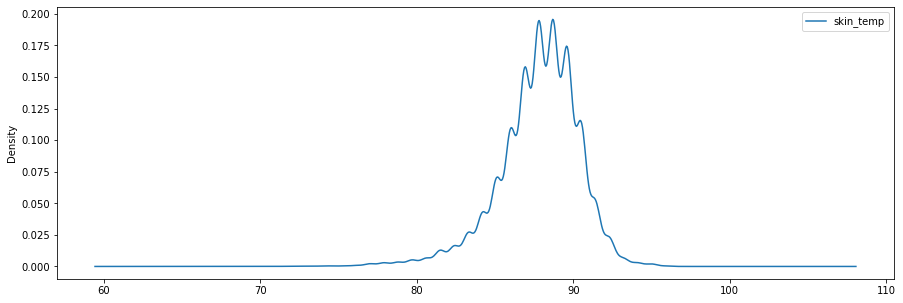

In [10]:
# Plot skin_temp
timeDfSt=timeDf.drop(['step','gsr', 'heart_rate','calories'],axis=1)
timeDfSt = timeDfSt[pd.notnull(timeDfSt['skin_temp'])] #-> ça c'est pour enlever toutes les entrées ou il y a NaN ou Null
timeDfSt=timeDfSt.astype(float)
timeDfSt=timeDfSt.sort_index(axis=0)
plt.rcParams.update({'figure.figsize': (15,5)})
timeDfSt.plot()
timeDfSt.plot.kde()


## Calories

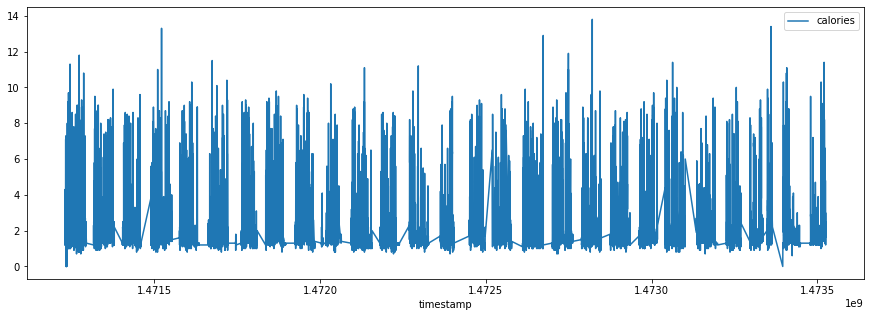

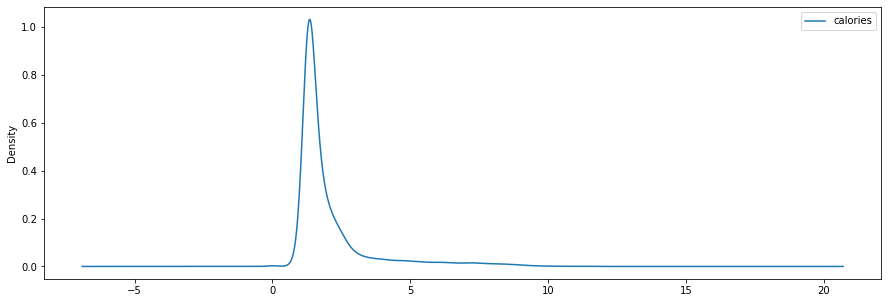

In [11]:
# Plot calories
timeDfC=timeDf.drop(['step','gsr', 'heart_rate','skin_temp'],axis=1)
timeDfC = timeDfC[pd.notnull(timeDfC['calories'])] #-> ça c'est pour enlever toutes les entrées ou il y a NaN ou Null
timeDfC=timeDfC.astype(float)
timeDfC=timeDfC.sort_index(axis=0)
plt.rcParams.update({'figure.figsize': (15,5)})
#timeDfC.reset_index().plot.scatter(x='timestamp', y='calories')
timeDfC.plot()
timeDfC.plot.kde()


## Steps

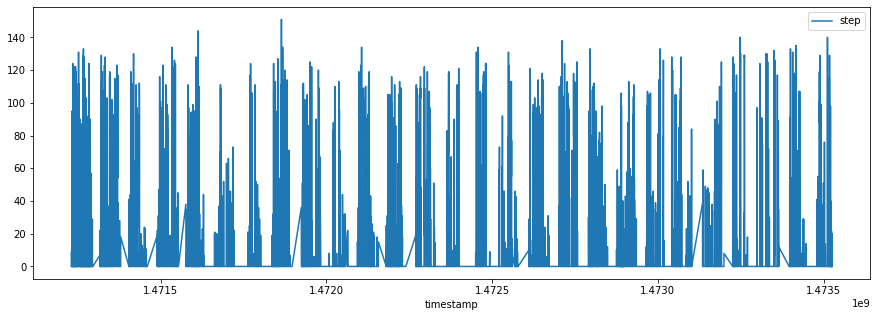

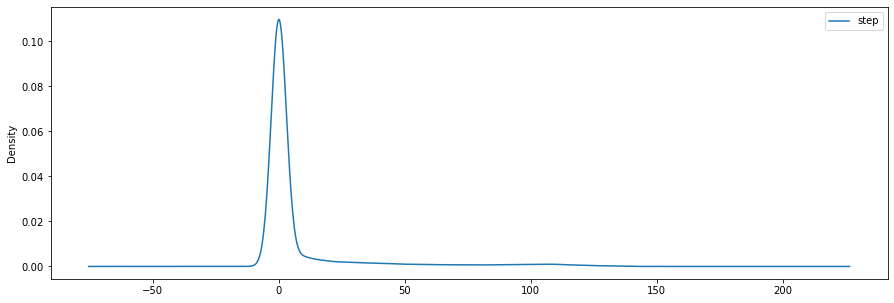

In [12]:
# Plot steps
timeDfC=timeDf.drop(['calories','gsr', 'heart_rate','skin_temp'],axis=1)
timeDfC = timeDfC[pd.notnull(timeDfC['step'])] #-> ça c'est pour enlever toutes les entrées ou il y a NaN ou Null
timeDfC=timeDfC.astype(float)
timeDfC=timeDfC.sort_index(axis=0)
plt.rcParams.update({'figure.figsize': (15,5)})
#timeDfC.reset_index().plot.bar(x='timestamp', y='step')
timeDfC.plot()
timeDfC.plot.kde()